In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px

from tslearn.clustering import TimeSeriesKMeans
from tslearn.clustering import silhouette_score

from scipy.cluster.hierarchy import single, complete, average, ward, dendrogram
from tslearn.metrics import cdist_dtw
from scipy.spatial.distance import euclidean
from sklearn.cluster import AgglomerativeClustering

c:\Users\96gar\anaconda3\envs\TFM_prediccion_promocional_env\lib\site-packages\tslearn\bases\bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


In [2]:
seed = 0
np.random.seed(seed)

In [3]:
df = pd.read_csv('../Data/Datos_enriquecidos.csv')
df.head()

,idSku,idSecuencia,udsVenta,bolOpen,bolHoliday,day_of_week_6,udsVenta_diff_1,udsVenta_diff_2,udsVenta_diff_3,udsVenta_diff_4,...,udsVenta_rolling_sum_8,udsVenta_rolling_max_8,udsVenta_rolling_mean_8,udsVenta_rolling_median_8,udsVenta_rolling_min_4,udsVenta_rolling_std_4,udsVenta_rolling_std_8,udsVenta_rolling_std_2,promo,udsVenta_rolling_min_8
0,1,2020-06-16,9,1,0,0,-21.0,9.0,-15.0,9.0,...,108.0,30.0,13.500,12.0,0.0,13.720423,10.993505,14.849242,1,0.0
1,1,2020-06-17,3,1,0,0,-6.0,-27.0,3.0,-21.0,...,102.0,30.0,12.750,12.0,0.0,13.527749,11.535659,4.242641,1,0.0
2,1,2020-06-18,33,1,0,0,30.0,24.0,3.0,33.0,...,114.0,33.0,14.250,12.0,3.0,14.974979,13.392429,21.213203,1,0.0
3,1,2020-06-19,21,1,0,0,-12.0,18.0,12.0,-9.0,...,120.0,33.0,15.000,15.0,3.0,13.304135,13.606721,8.485281,1,0.0
4,1,2020-06-20,15,1,0,0,-6.0,-18.0,12.0,6.0,...,135.0,33.0,16.875,18.0,3.0,12.489996,12.205824,4.242641,1,0.0


In [4]:
# filtrar columnas idSku, idSecuencia, udsVenta
df = df[['idSku', 'idSecuencia', 'udsVenta']]
# transformar idSecuencia a datetime
df['idSecuencia'] = pd.to_datetime(df['idSecuencia'])
df.head()

,idSku,idSecuencia,udsVenta
0,1,2020-06-16,9
1,1,2020-06-17,3
2,1,2020-06-18,33
3,1,2020-06-19,21
4,1,2020-06-20,15


In [5]:
# crear dataframe con los datos agrupados por idSku y por semana
df_agg = df.groupby(['idSku', pd.Grouper(key='idSecuencia', freq='W')])['udsVenta'].sum().reset_index()
df_agg.head()

,idSku,idSecuencia,udsVenta
0,1,2020-06-21,81
1,1,2020-06-28,102
2,1,2020-07-05,123
3,1,2020-07-12,93
4,1,2020-07-19,105


In [6]:
# pivotar el dataframe para obtener un array de 3 dimensiones
df_pivot = df_agg.pivot(index='idSku', columns='idSecuencia', values='udsVenta')
X = df_pivot.to_numpy()
X = X.reshape((X.shape[0], X.shape[1], 1))
X.shape

(50, 92, 1)

# k-means clustering

In [7]:
# usar elbow method y silhouette determinar el número de clusters
n_clusters = X.shape[0]
wcss = []
silhouette = []
for i in range(2, n_clusters):
    kmeans = TimeSeriesKMeans(n_clusters=i, metric="euclidean", random_state=seed).fit(X)
    wcss.append(kmeans.inertia_)
    s = silhouette_score(X, kmeans.labels_, metric="euclidean")
    silhouette.append(s)

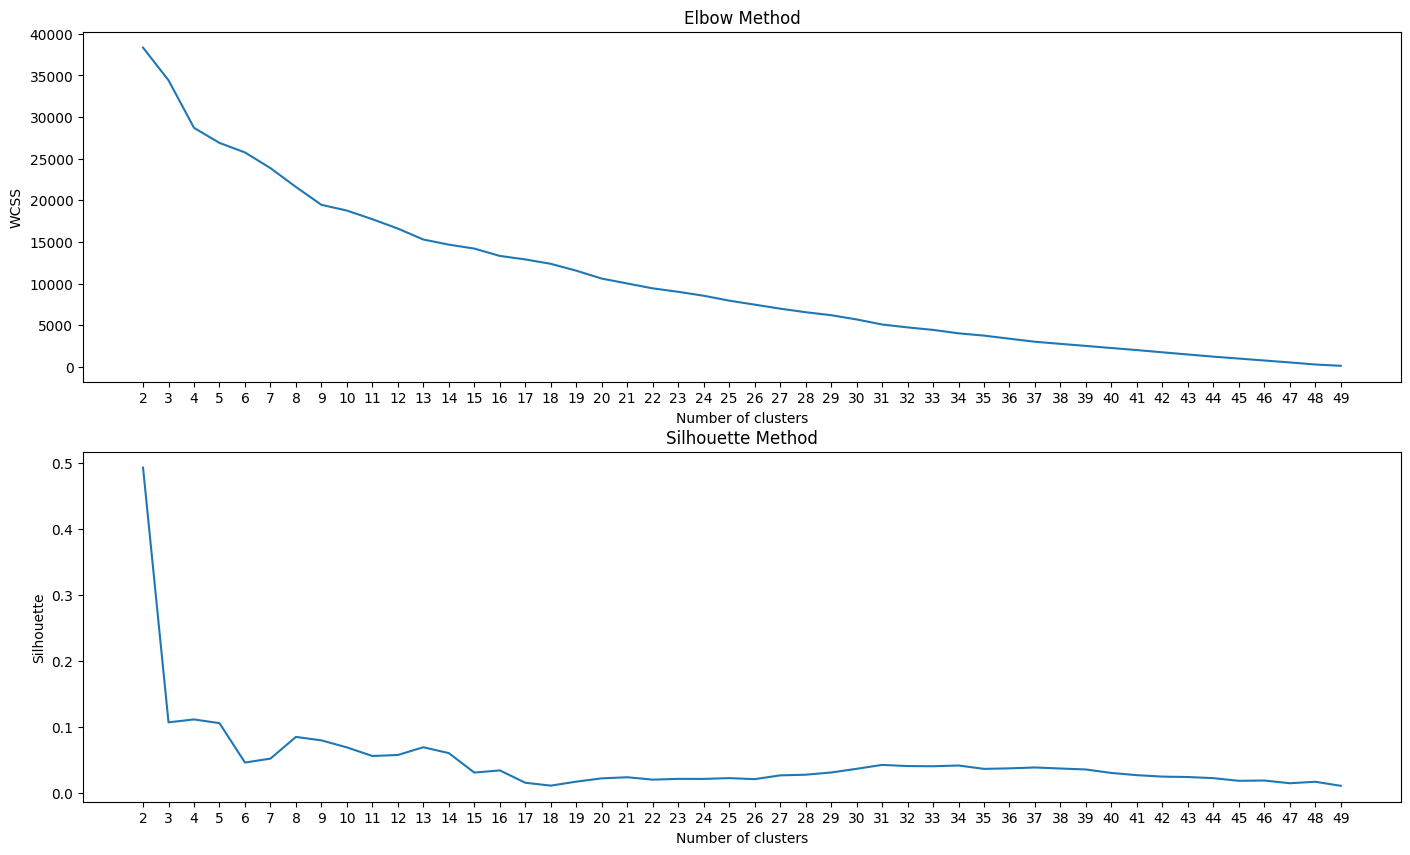

In [8]:
# 2 plots para visualizar los resultados y determinar el número de clusters
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(17, 10))
ax1.plot(range(2, n_clusters), wcss)
ax1.set_title('Elbow Method')
ax1.set_xlabel('Number of clusters')
ax1.set_ylabel('WCSS')
ax2.plot(range(2, n_clusters), silhouette)
ax2.set_title('Silhouette Method')
ax2.set_xlabel('Number of clusters')
ax2.set_ylabel('Silhouette')
ax1.set_xticks(range(2, n_clusters))
ax2.set_xticks(range(2, n_clusters))
plt.show()

In [9]:
# crear clusters con el número de clusters determinado
kmeans = TimeSeriesKMeans(n_clusters=13, metric="euclidean", random_state=seed).fit(X)
labels = kmeans.labels_
# añadir la columna cluster al dataframe
df_labels = pd.DataFrame(labels, columns=['cluster'])
df_labels['idSku'] = df_labels.index
# copiar el dataframe original y añadir la columna cluster
df_clusters = df_agg.copy()
df_clusters = df_clusters.merge(df_labels, on='idSku')
df_clusters.head()

,idSku,idSecuencia,udsVenta,cluster
0,1,2020-06-21,81,8
1,1,2020-06-28,102,8
2,1,2020-07-05,123,8
3,1,2020-07-12,93,8
4,1,2020-07-19,105,8


In [10]:
# plot de los clusters
for i in range(0, 13):
    df_cluster = df_clusters[df_clusters['cluster'] == i]
    df_cluster = df_cluster.pivot(index='idSecuencia', columns='idSku', values='udsVenta')
    df_cluster = df_cluster.fillna(0)
    df_cluster = df_cluster.reset_index()
    df_cluster = df_cluster.melt(id_vars=['idSecuencia'], var_name='idSku', value_name='udsVenta')
    fig = px.line(df_cluster, x='idSecuencia', y='udsVenta', color='idSku', title='Cluster ' + str(i))
    fig.show()

In [11]:
# usar elbow method y silhouette determinar el número de clusters
n_clusters = X.shape[0]
wcss = []
silhouette = []
for i in range(2, n_clusters):
    kmeans = TimeSeriesKMeans(n_clusters=i, metric="dtw", random_state=seed).fit(X)
    wcss.append(kmeans.inertia_)
    s = silhouette_score(X, kmeans.labels_, metric="dtw")
    silhouette.append(s)

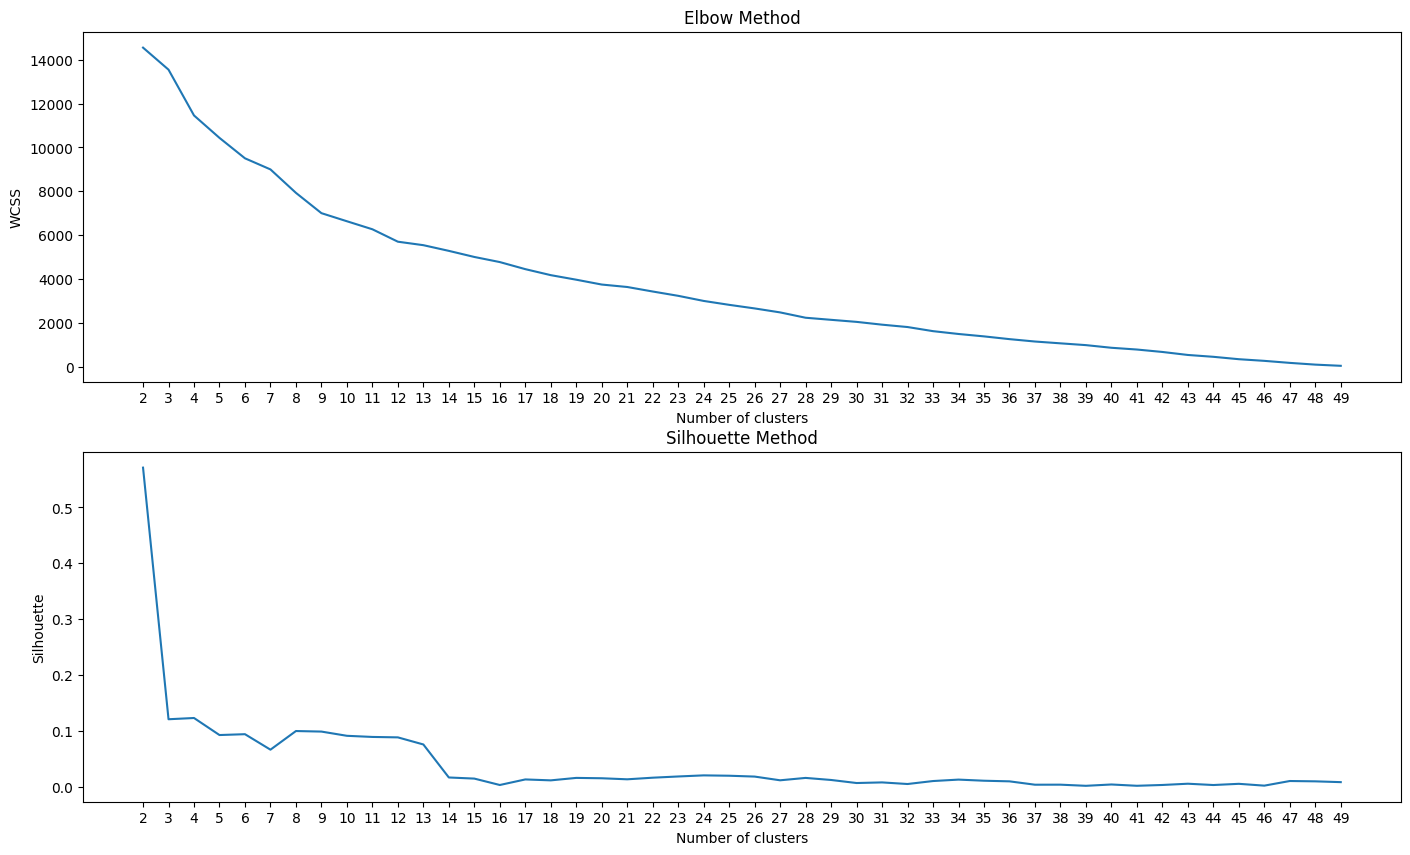

In [12]:
# 2 plots para visualizar los resultados y determinar el número de clusters
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(17, 10))
ax1.plot(range(2, n_clusters), wcss)
ax1.set_title('Elbow Method')
ax1.set_xlabel('Number of clusters')
ax1.set_ylabel('WCSS')
ax2.plot(range(2, n_clusters), silhouette)
ax2.set_title('Silhouette Method')
ax2.set_xlabel('Number of clusters')
ax2.set_ylabel('Silhouette')
ax1.set_xticks(range(2, n_clusters))
ax2.set_xticks(range(2, n_clusters))
plt.show()

In [13]:
# crear clusters con el número de clusters determinado
kmeans = TimeSeriesKMeans(n_clusters=12, metric="dtw", random_state=seed).fit(X)
labels = kmeans.labels_
# añadir la columna cluster al dataframe
df_labels = pd.DataFrame(labels, columns=['cluster'])
df_labels['idSku'] = df_labels.index
# copiar el dataframe original y añadir la columna cluster
df_clusters = df_agg.copy()
df_clusters = df_clusters.merge(df_labels, on='idSku')
df_clusters.head()

,idSku,idSecuencia,udsVenta,cluster
0,1,2020-06-21,81,8
1,1,2020-06-28,102,8
2,1,2020-07-05,123,8
3,1,2020-07-12,93,8
4,1,2020-07-19,105,8


In [14]:
# plot de los clusters
for i in range(0, 12):
    df_cluster = df_clusters[df_clusters['cluster'] == i]
    df_cluster = df_cluster.pivot(index='idSecuencia', columns='idSku', values='udsVenta')
    df_cluster = df_cluster.fillna(0)
    df_cluster = df_cluster.reset_index()
    df_cluster = df_cluster.melt(id_vars=['idSecuencia'], var_name='idSku', value_name='udsVenta')
    fig = px.line(df_cluster, x='idSecuencia', y='udsVenta', color='idSku', title='Cluster ' + str(i))
    fig.show()

# Hierarchical clustering

In [15]:
def hclust_silouhette(dist_mat, method):
    silohuette = []
    for c in range(2, dist_mat.shape[0]):
        modelo_hclust_complete = AgglomerativeClustering(affinity='precomputed', linkage =method, n_clusters=c)
        cluster_labels = modelo_hclust_complete.fit_predict(dist_mat)
        s = silhouette_score(dist_mat, cluster_labels, metric="precomputed")
        silohuette.append(s)
    return(silohuette)

In [16]:
def hierarchical_clustering(dist_mat):
    # crear subplots para mostrar los dendrogramas y los resultados del silohuette
    fig, axes = plt.subplots(7, 1, figsize=(16, 48))
    # definir los métodos de linkage
    methods = ['single', 'complete', 'average', 'ward']
    for i, m in enumerate(methods):
        # calcular el linkage
        if m == 'ward':
            Z = ward(dist_mat)
        elif m == 'single':
            Z = single(dist_mat)
            silohuette = hclust_silouhette(dist_mat, 'single')
        elif m == 'complete':
            Z = complete(dist_mat)
            silohuette = hclust_silouhette(dist_mat, 'complete')
        elif m == 'average':
            Z = average(dist_mat)
            silohuette = hclust_silouhette(dist_mat, 'average')
        # plot del dendrogram
        dendrogram(Z, ax=axes[i*2])
        axes[i*2].set_title('Dendrogram for {}-linkage'.format(m))
        # plot del silohuette para los métodos que lo permiten
        if m != 'ward':
            axes[i*2+1].plot(range(2, dist_mat.shape[0]), silohuette)
    plt.show()

In [17]:
# función para calcular la distancia euclídea entre dos vectores
def euclidean_distance_matrix(X):
    distance_matrix = np.zeros((X.shape[0], X.shape[0]))
    shape = X.shape[1]
    for i in range(X.shape[0]):
        for j in range(X.shape[0]):
            distance_matrix[i, j] = euclidean(X[i].reshape(shape), X[j].reshape(shape))
    return distance_matrix

c:\Users\96gar\anaconda3\envs\TFM_prediccion_promocional_env\lib\site-packages\scipy\cluster\hierarchy.py:282: ClusterWarning:

scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix

c:\Users\96gar\anaconda3\envs\TFM_prediccion_promocional_env\lib\site-packages\scipy\cluster\hierarchy.py:364: ClusterWarning:

scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix

c:\Users\96gar\anaconda3\envs\TFM_prediccion_promocional_env\lib\site-packages\scipy\cluster\hierarchy.py:446: ClusterWarning:

scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix

c:\Users\96gar\anaconda3\envs\TFM_prediccion_promocional_env\lib\site-packages\scipy\cluster\hierarchy.py:834: ClusterWarning:

scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance 

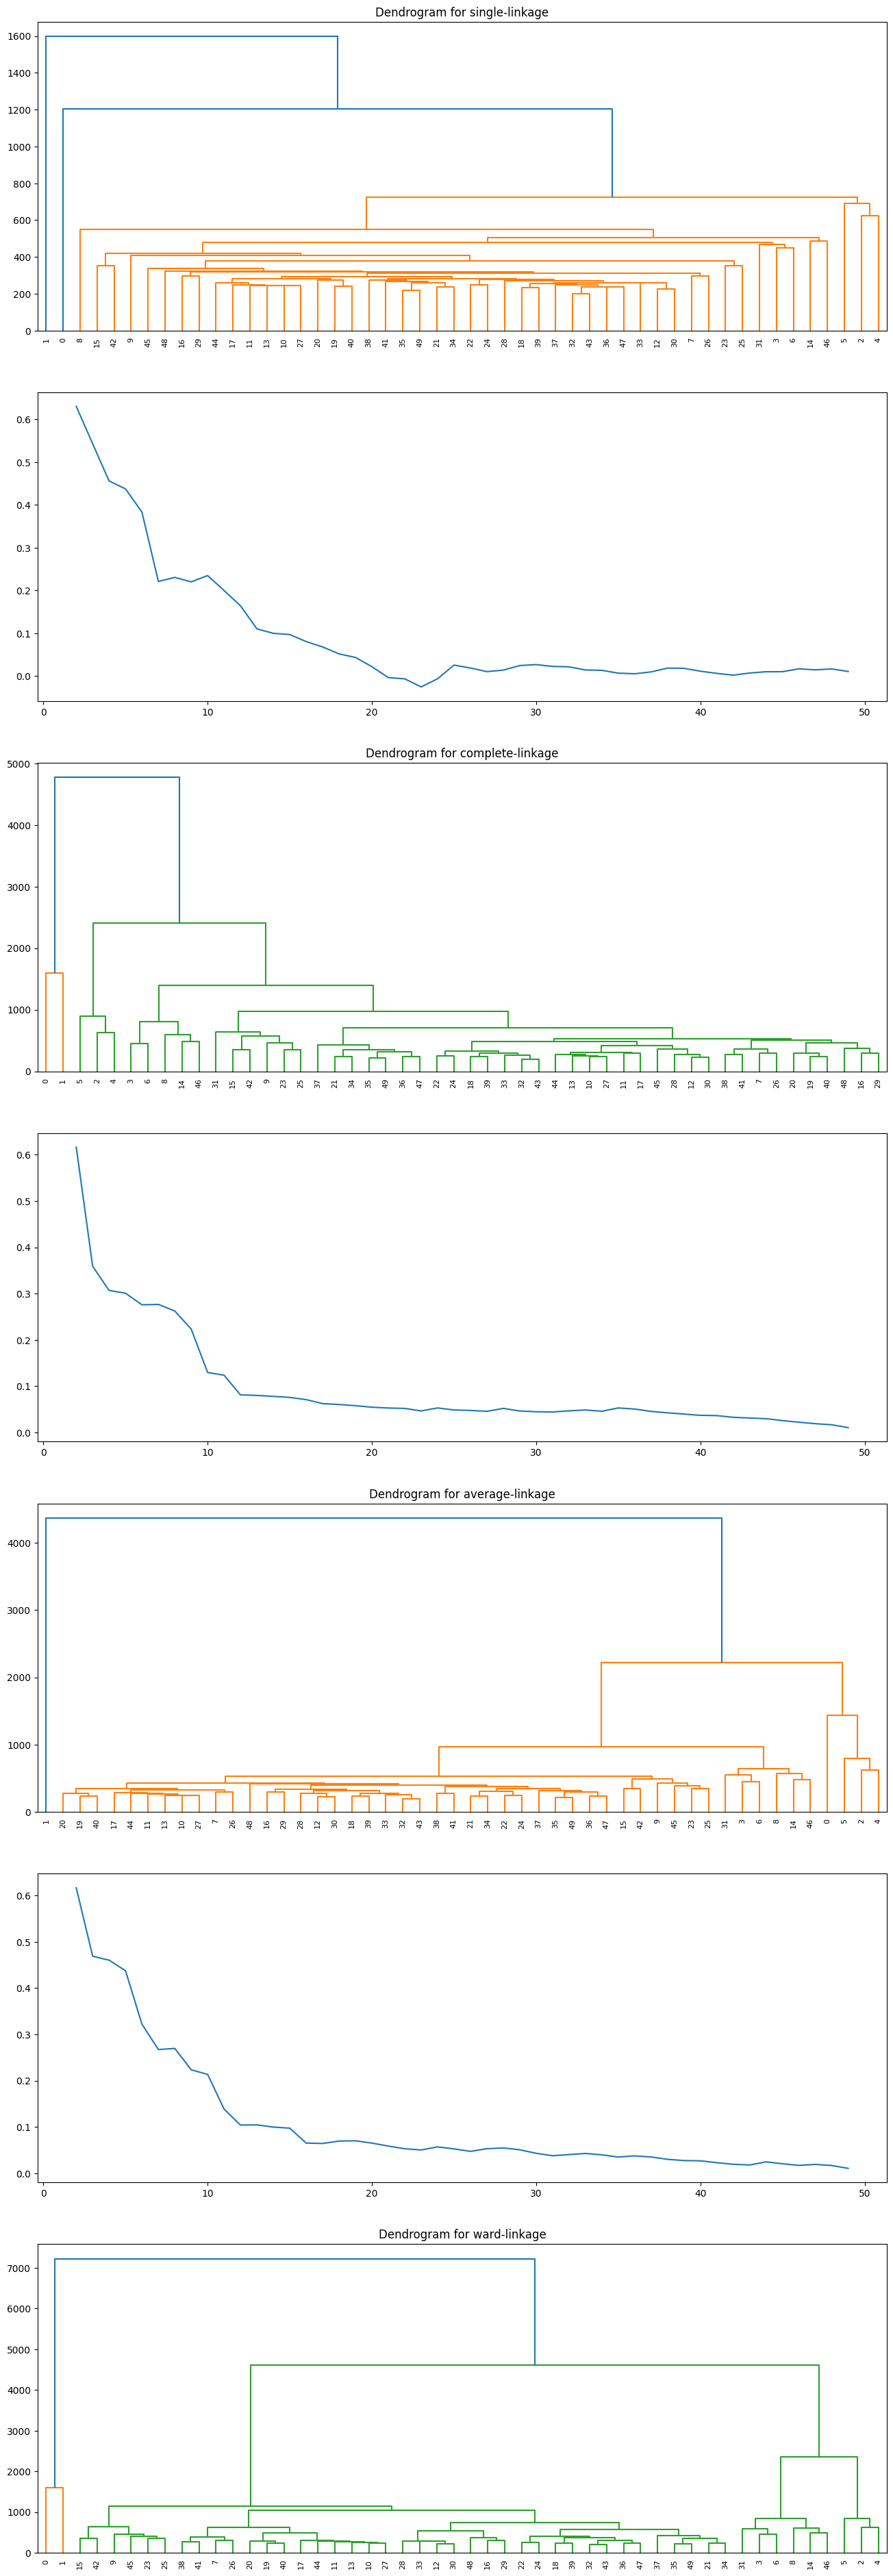

In [18]:
# calcular la distancia euclídea entre las series y aplicar mostrar los dendrogramas y los resultados del silohuette
distance_matrix_euclidean = euclidean_distance_matrix(X)
_ = hierarchical_clustering(distance_matrix_euclidean)

c:\Users\96gar\anaconda3\envs\TFM_prediccion_promocional_env\lib\site-packages\scipy\cluster\hierarchy.py:282: ClusterWarning:

scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix

c:\Users\96gar\anaconda3\envs\TFM_prediccion_promocional_env\lib\site-packages\scipy\cluster\hierarchy.py:364: ClusterWarning:

scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix

c:\Users\96gar\anaconda3\envs\TFM_prediccion_promocional_env\lib\site-packages\scipy\cluster\hierarchy.py:446: ClusterWarning:

scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix

c:\Users\96gar\anaconda3\envs\TFM_prediccion_promocional_env\lib\site-packages\scipy\cluster\hierarchy.py:834: ClusterWarning:

scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance 

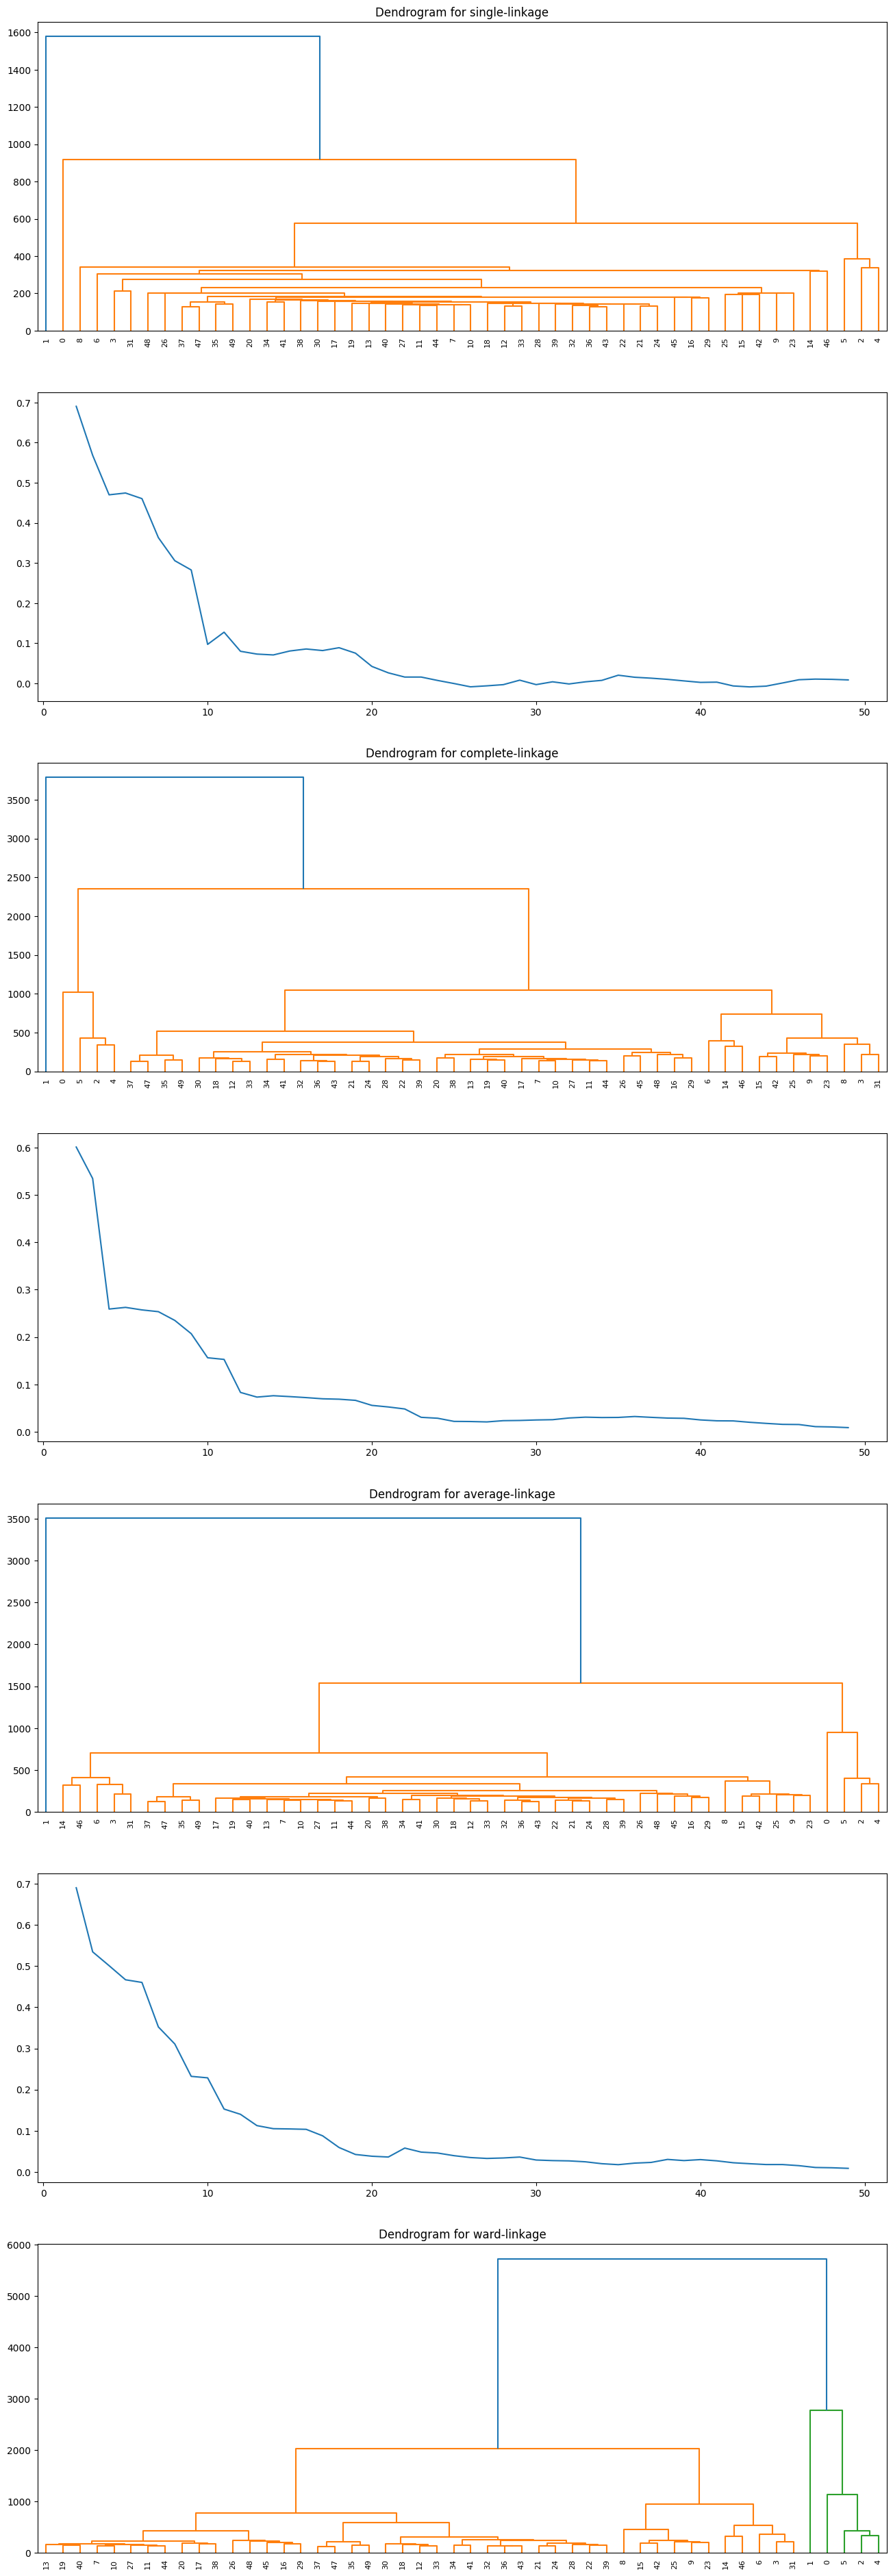

In [19]:
# calcular la distancia mediante dinamic time warping entre las series y aplicar mostrar los dendrogramas y los resultados del silohuette
distance_matrix_dtw = cdist_dtw(X)
_ = hierarchical_clustering(distance_matrix_dtw)

In [26]:
# mostramos las series con las distancias euclídeas más pequeñas
df_dist = pd.DataFrame(distance_matrix_euclidean)
df_dist = df_dist.stack().reset_index()
df_dist.columns = ['idSku1', 'idSku2', 'distance']
df_dist = df_dist[df_dist['idSku1'] != df_dist['idSku2']]
df_dist = df_dist.sort_values(by='distance')
df_dist = df_dist.drop_duplicates(subset=['distance'])
for i in range(0, 5):
    min_distance_index = [df_dist.iloc[i]['idSku1'], df_dist.iloc[i]['idSku2']]
    df_agg_min_distance = df_agg[df_agg['idSku'].isin(min_distance_index)]
    fig = px.line(df_agg_min_distance, x="idSecuencia", y="udsVenta", color='idSku', title='UdsVenta para cada sku en cada semana')
    fig.show()
    df_min_distance = df[df['idSku'].isin(min_distance_index)]
    fig = px.line(df_min_distance, x="idSecuencia", y="udsVenta", color='idSku', title='UdsVenta para cada sku en cada fecha')
    fig.show()

In [25]:
# mostramos las series con las distancias DTW más pequeñas
df_dist = pd.DataFrame(distance_matrix_dtw)
df_dist = df_dist.stack().reset_index()
df_dist.columns = ['idSku1', 'idSku2', 'distance']
df_dist = df_dist[df_dist['idSku1'] != df_dist['idSku2']]
df_dist = df_dist.sort_values(by='distance')
df_dist = df_dist.drop_duplicates(subset=['distance'])
for i in range(0, 5):
    min_distance_index = [df_dist.iloc[i]['idSku1'], df_dist.iloc[i]['idSku2']]
    df_agg_min_distance = df_agg[df_agg['idSku'].isin(min_distance_index)]
    fig = px.line(df_agg_min_distance, x="idSecuencia", y="udsVenta", color='idSku', title='UdsVenta para cada sku en cada semana')
    fig.show()
    df_min_distance = df[df['idSku'].isin(min_distance_index)]
    fig = px.line(df_min_distance, x="idSecuencia", y="udsVenta", color='idSku', title='UdsVenta para cada sku en cada fecha')
    fig.show()

(<Figure size 640x480 with 2 Axes>,
 array([<AxesSubplot:>, <AxesSubplot:>], dtype=object))

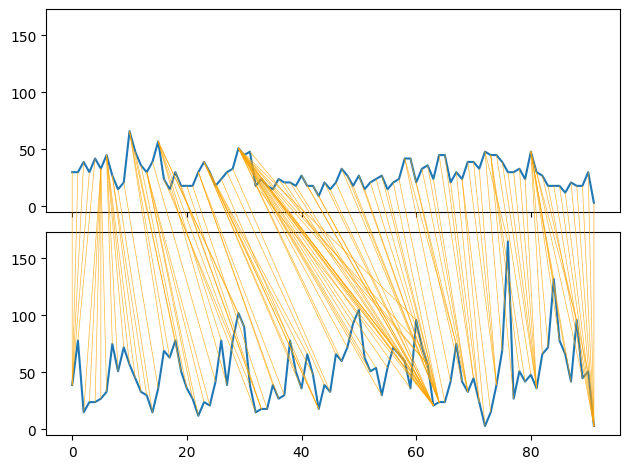

In [22]:
from dtaidistance import dtw
from dtaidistance import dtw_visualisation as dtwvis
s1 = df_agg[df_agg['idSku'] == 37]['udsVenta'].to_numpy()
s2 = df_agg[df_agg['idSku'] == 47]['udsVenta'].to_numpy()
path = dtw.warping_path(s1, s2)
dtwvis.plot_warping(s1, s2, path)